In [1]:
!export PATH=/Library/TeX/texbin:$PATH

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
import sys
import os
import io
import math
import scipy
import astropy.io.fits as fits
import astropy.units as u
import astropy.coordinates as coord
import pandas as pd
import matplotlib.lines as mlines
from astropy.cosmology import Planck13, Planck18, z_at_value
from astropy.coordinates import SkyCoord
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy import constants as const
from scipy.integrate import quad, dblquad, solve_ivp
from colossus.lss import mass_function

#plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
path ='/Users/josephine/Desktop/Yale_2/COSM/'
#cosmology used
Omegam0,Omegab0, h, n, s8 = 0.3175, 0.049, 0.6711, 0.9624, 0.834
Omega_L0 = 1-0.3175

$\mathrm{\textbf{Plot of Linear Power Spectrum at z=0}}\\\\$
At low k, I plot 𝑃(𝑘) ∝ 𝑘^𝑛𝑠, for ns = 1 (Harrison-Zel’dovich spectrum) (red) and ns = 0.9624 (our cosmology) (green). I see a slightly deviation from ns=1, the ns=0.96 slope matches better with the data. 
I overplotted the scipy interpolated linear power spectrum (that is used later). 
I read of k_peak ~ 0.01 h/Mpc, similar to expectation (comparing to question III equality scale). 

<IPython.core.display.Javascript object>


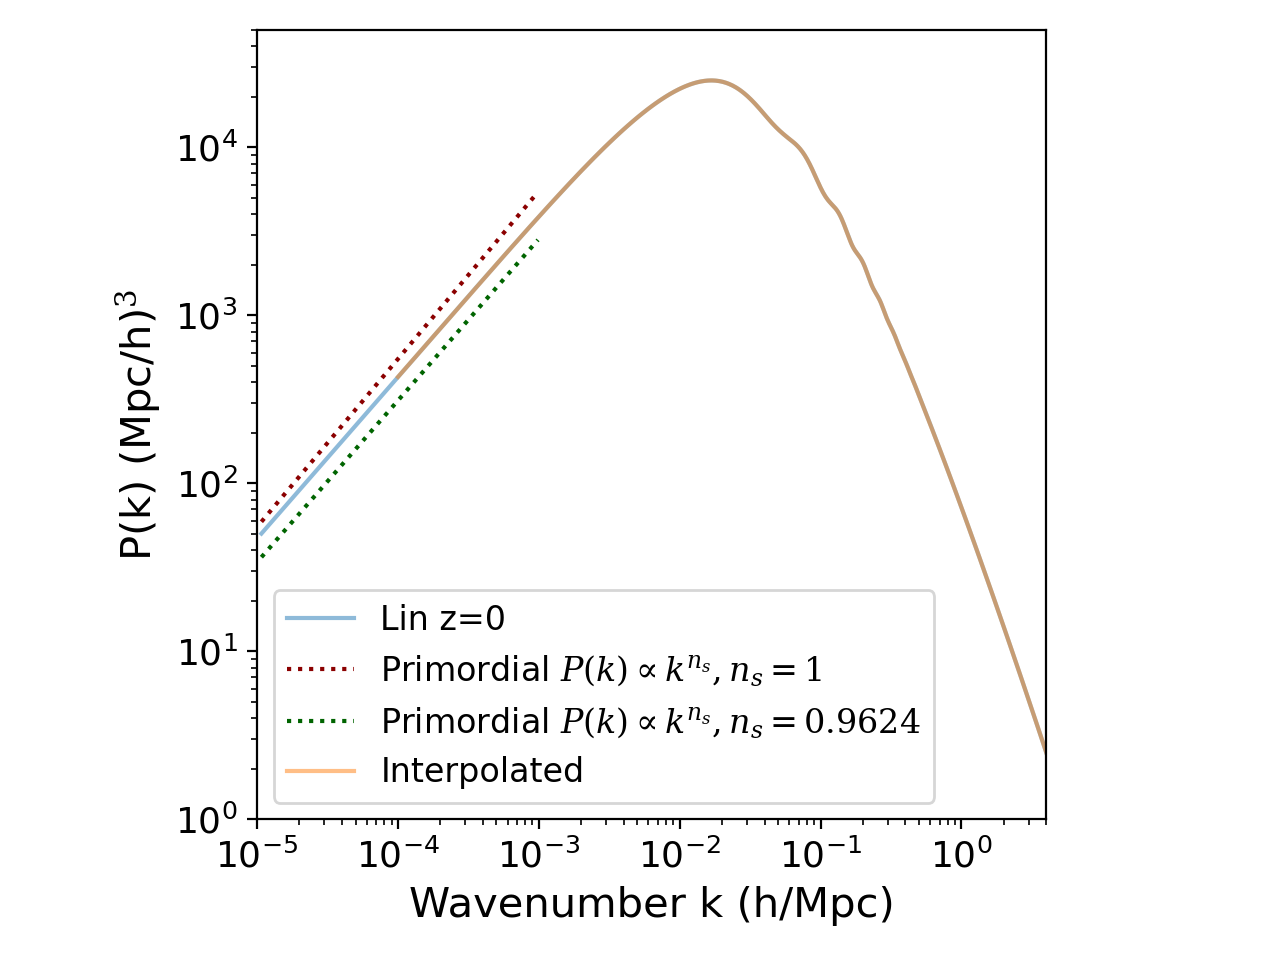

In [3]:

dtypes = np.array([float, float])
k_lin, Pk_lin = np.genfromtxt(path+ 'HW5/linear_pk.txt', delimiter='    ', unpack =True, dtype=dtypes) #k (h/Mpc) and P(k) (Mpc/h)^3
#𝑃(𝑘) ∝ 𝑘𝑛𝑠

Pk_primordial_ns1 = 5.5e6 * k_lin**(1)
Pk_primordial_ns = 2.2e6 * k_lin**(0.9624)

P_interp_lin = scipy.interpolate.interp1d(k_lin,Pk_lin , kind='cubic', fill_value='extrapolate')
k_fine =  np.logspace(-4, 2, 10000)

fig = plt.figure()
ax=fig.add_subplot()
ax.plot(k_lin, Pk_lin, label='Lin z=0', alpha=0.5)
ax.plot(k_lin[np.where(k_lin<1e-3)[0]], Pk_primordial_ns1[np.where(k_lin<1e-3)[0]], label='Primordial $P(k) \propto k^{n_s}, n_s=1$', ls='dotted', color='darkred')
ax.plot(k_lin[np.where(k_lin<1e-3)[0]], Pk_primordial_ns[np.where(k_lin<1e-3)[0]], label='Primordial $P(k) \propto k^{n_s}, n_s=0.9624$', ls='dotted', color='darkgreen')
ax.plot(k_fine, P_interp_lin(k_fine), label='Interpolated', alpha=0.5)
ax.set_xlabel(r'Wavenumber k (h/Mpc)', fontsize=15)
ax.set_ylabel(r'P(k) (Mpc/h)$^3$', fontsize=15)
ax.set_xlim(1e-5, 4)
ax.set_ylim(1e0, 5e4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.minorticks_on()
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.tight_layout()
plt.show()

$\mathrm{\textbf{Tranfer Function}}\\\\$
The transfer function 𝑇(𝑘) is defined as the function that transforms the primordial power spectrum Pi into P(k):
P(k) = Pi * 𝑇^2(𝑘). 
P is the linear power spectrum from the data and Pi is the primordial, like calculated above with ns=0.9426. The normalization is done by setting it to 1 at low k (I chose log(k)=-3). 

<IPython.core.display.Javascript object>


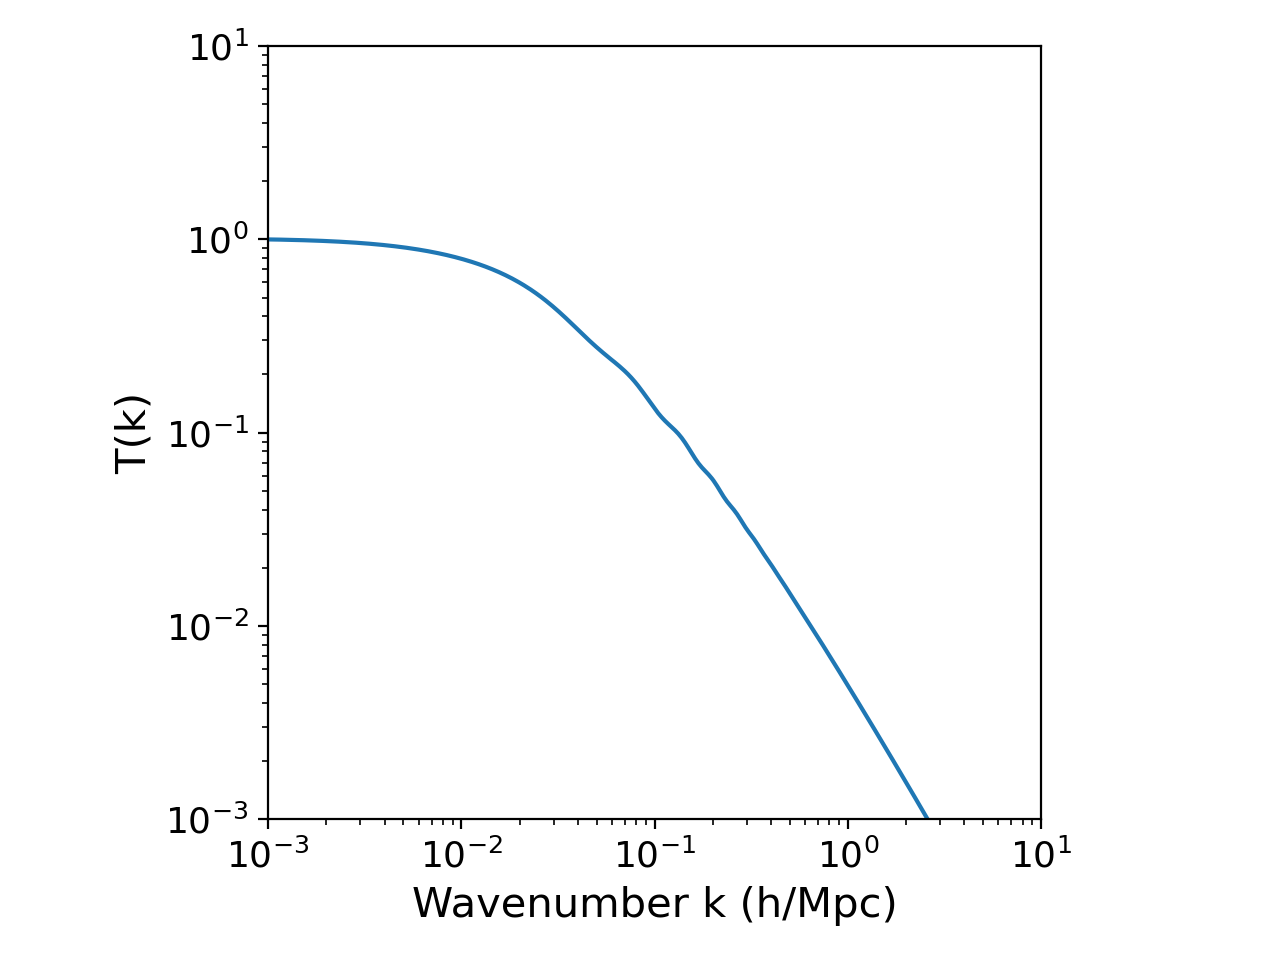

In [4]:
T_k = np.sqrt(Pk_lin/Pk_primordial_ns)
normalization_factor = T_k[np.where(k_lin<1e-3)[0][-1]]#normalized at log_10(k)=-3

fig = plt.figure()
ax=fig.add_subplot()
ax.plot(k_lin, T_k/normalization_factor)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Wavenumber k (h/Mpc)', fontsize=15)
ax.set_ylabel(r'T(k)', fontsize=15)
ax.set_ylim(1e-3, 10)
ax.set_xlim(1e-3, 10)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.tight_layout()
plt.show()


$\mathrm{\textbf{𝜎8 from the linear power spectrum}}\\\\$
I calculate 𝜎8 from the following:
$\sigma_8^2=1/(2\pi^2)\int W^2 k^2 P(k)dk\\\\$
Here W is for the tophat filter in fourier space. 
I find 0.8335, exactly the same as given in our cosmology $\sigma_8 = 0.834 $. 

In [5]:
def tophat(kR):
	W_tilde = 3/(kR)**3 * (np.sin(kR) - kR*np.cos(kR))
	return W_tilde

def integrand(k, Ri, n):
    return (k)**2 * P_k(k) * np.abs(tophat(k*Ri)**2) #dk
    
def sigma_squared(Ri, n):
	
	integral = quad(integrand, 0, np.inf, args = (Ri, n)) 
	return 1/(2*np.pi**2)  * integral[0]

def P_k(k):
	return P_interp_lin(k) #P_interp_lin was the interpolated function from above 

In [6]:
sigma_8 = np.sqrt(sigma_squared(8, n))
print(sigma_8) #0.833!!!!

0.8335126029557834


/var/folders/bg/b8pbm9h90v9d199r8jsxsf840000gn/T/ipykernel_16549/25706461.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = quad(integrand, 0, np.inf, args = (Ri, n))


$\mathrm{\textbf{Non-linear Power Spectrum and Structure Growth}}\\\\$
In the left plot I show the power spectrum from the simulation at the redshifts in orange, green, red purple for z=0, z=0.5, z=1 and z=2, respectively. I also added linear power spectrum (smooth blue line) from before. I compare the linear power spectrum to the power spectrum from simulations at z=0 in the right plot, it is noisy, but it is roughly 1 around the peak, k_eq, and then increasing in k (smaller scales) there is more power in the simulation power spectrum compared to the linear power spectrum. Due to structure formation, non-linear collapse there are more objects with smaller structures.

<IPython.core.display.Javascript object>


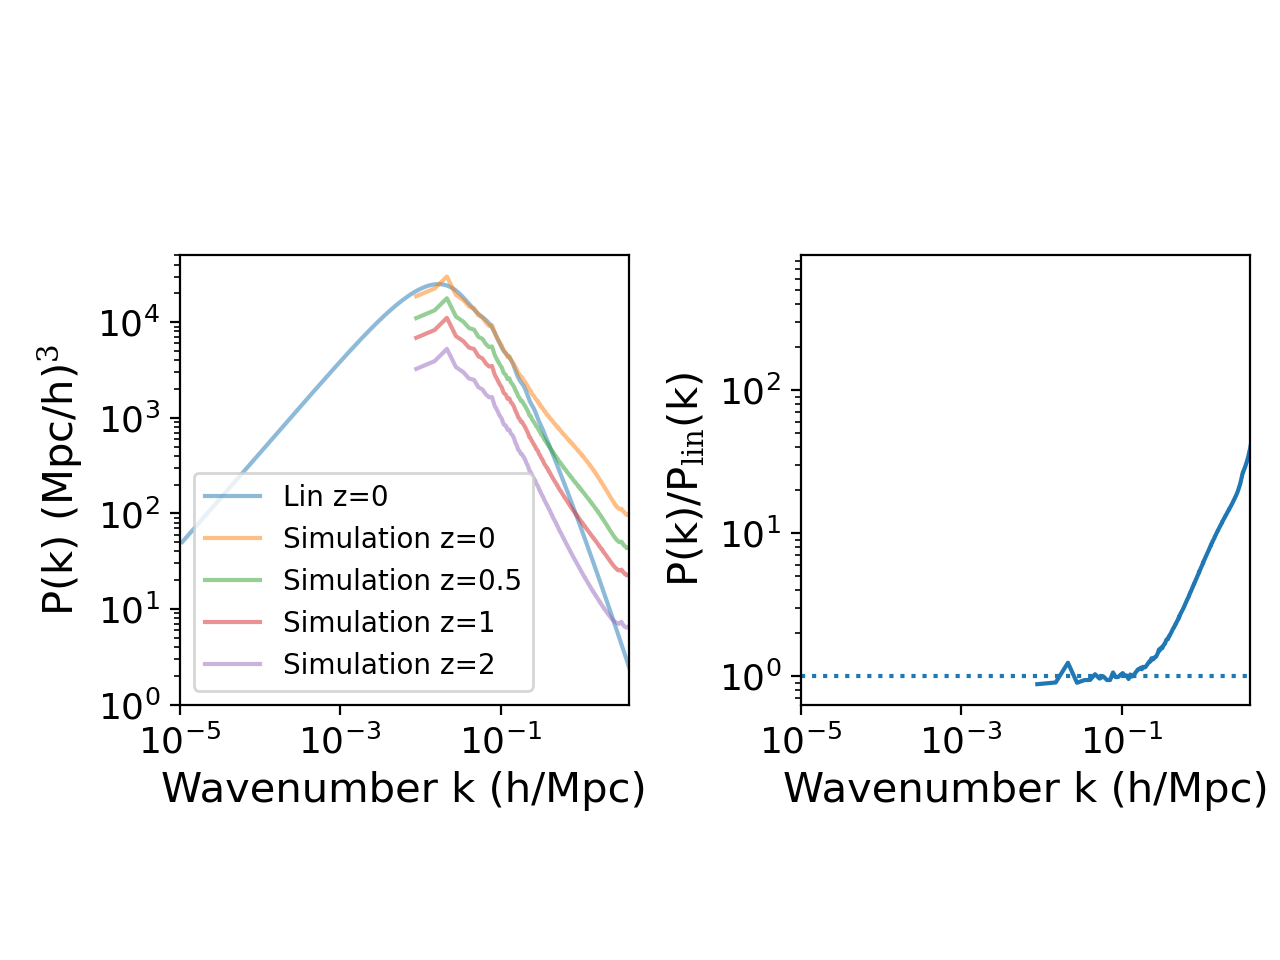

In [7]:
dtypes = np.array([float, float])

k_lin, Pk_lin = np.genfromtxt(path+ 'HW5/linear_pk.txt', delimiter='    ', unpack =True, dtype=dtypes) #k (h/Mpc) and P(k) (Mpc/h)^3
k, Pk_z0 = np.genfromtxt(path+ 'HW5/Pk_m_z=0.txt', delimiter='	', unpack =True, dtype=dtypes) #k (h/Mpc) and P(k) (Mpc/h)^3s
P_interp_z0 = scipy.interpolate.interp1d(k,Pk_z0 , kind='linear')

k, Pk_z05 = np.genfromtxt(path+ 'HW5/Pk_m_z=0.5.txt', delimiter='	', unpack =True, dtype=dtypes) #k (h/Mpc) and P(k) (Mpc/h)^3
P_interp_z05 = scipy.interpolate.interp1d(k,Pk_z05 , kind='linear')
k, Pk_z1 = np.genfromtxt(path+ 'HW5/Pk_m_z=1.txt', delimiter='	', unpack =True, dtype=dtypes) #k (h/Mpc) and P(k) (Mpc/h)^3
P_interp_z1 = scipy.interpolate.interp1d(k,Pk_z1 , kind='linear')
k, Pk_z2 = np.genfromtxt(path+ 'HW5/Pk_m_z=2.txt', delimiter='	', unpack =True, dtype=dtypes) #k (h/Mpc) and P(k) (Mpc/h)^3
P_interp_z2 = scipy.interpolate.interp1d(k,Pk_z2 , kind='linear')

	
fig = plt.figure()
ax=fig.add_subplot(121)
ax.plot(k_lin, Pk_lin, label='Lin z=0', alpha=0.5)
ax.plot(k, Pk_z0, label='Simulation z=0', alpha=0.5)
ax.plot(k, Pk_z05, label='Simulation z=0.5', alpha=0.5)
ax.plot(k, Pk_z1, label='Simulation z=1', alpha=0.5)
ax.plot(k, Pk_z2, label='Simulation z=2', alpha=0.5)

ax.set_xlabel(r'Wavenumber k (h/Mpc)', fontsize=15)
ax.set_ylabel(r'P(k) (Mpc/h)$^3$', fontsize=15)
ax.set_xlim(1e-5, 4)
ax.set_ylim(1e0, 5e4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.minorticks_on()
ax.legend()
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')


ax2 = fig.add_subplot(122)
ax2.plot(k, P_interp_z0(k)/P_interp_lin(k))
ax2.set_xlim(1e-5, 4)
#ax2.set_ylim(0, 100)
ax2.axhline(1, ls='dotted')
ax2.set_xlabel(r'Wavenumber k (h/Mpc)', fontsize=15)
ax2.set_ylabel(r'P(k)/P$_{\mathrm{lin}}$(k)', fontsize=15)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.minorticks_on()
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.set_aspect(1.0/ax2.get_data_ratio(), adjustable='box')
plt.tight_layout()
plt.show()



$\mathrm{\textbf{Growth function}}\\\\$
We see that as we go to higher redshifts, the peak of the power spectrum drops and this is a measure of the growth function. 
$\\\\P(k,t) = D_+^2(t) P_0(k)$
At keq ~1e-2 I calculate the peak height of the power spectrum. So $\\\\D_+(z=0.5) = \sqrt{\frac{P(k, z=0.5)}{P(k,z=0)}}$
$\\\\D_+(z=1) = \sqrt{\frac{P(k, z=1)}{P(k,z=0)}}$
$\\\\D_+(z=2) = \sqrt{\frac{P(k, z=2)}{P(k,z=0)}}$
This is now also normalized, $D_+(z=0) =1$, at z=0 the growth rate is 1. 
This gives 4 datapoints for which I again do interpolation. 


<IPython.core.display.Javascript object>


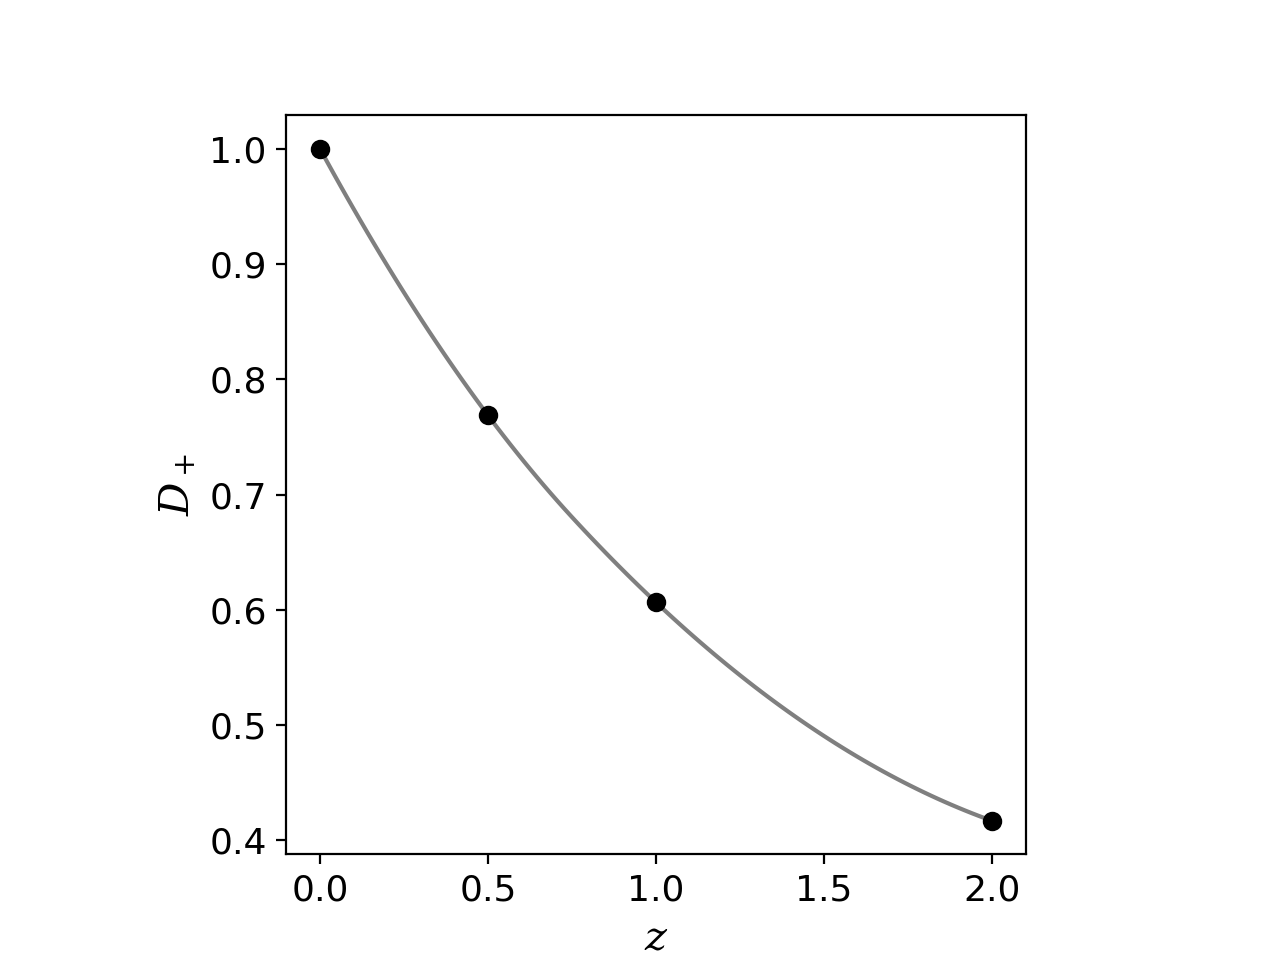

In [8]:

D_plus_05 = np.sqrt(P_interp_z05(1e-2)/P_interp_z0(1e-2))
D_plus_1 = np.sqrt(P_interp_z1(1e-2)/P_interp_z0(1e-2))
D_plus_2 = np.sqrt(P_interp_z2(1e-2)/P_interp_z0(1e-2))
D_plus = [1, D_plus_05, D_plus_1, D_plus_2]
z = [0, 0.5, 1, 2]
D = scipy.interpolate.interp1d(z,D_plus , kind='quadratic')
z_fine = np.linspace(0,2,100)

fig = plt.figure()
ax=fig.add_subplot(111)
ax.scatter(z, D_plus, color='black')
ax.plot(z_fine, D(z_fine), color='black', alpha=0.5)
ax.set_xlabel(r'$z$', fontsize=15)
ax.set_ylabel(r'$D_+$', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.show()

$\mathrm{\textbf{Computing the Growth function}}\\\\$
$𝐷(𝑎) ≡ 𝑔(𝑎)𝑎$
$\\\\𝑔′′ + (5/2 − 3/2𝑤(𝑎)Ω𝐷𝐸(𝑎)) 𝑔′ + 3/2(1 − 𝑤(𝑎))Ω𝐷𝐸(𝑎)𝑔 = 0 .$
𝑤(𝑎) = −1, so $\rho_{DE} = \rho_{\Lambda}$ = constant with time.
$\\\\\rho_{crit}(z) = 3H^2/(8\pi G)$
$\Omega_{\Lambda} = \rho_{\Lambda,0} /\rho_{crit} =\Omega_{\Lambda,0}\rho_{crit,0}/\rho_{crit} = \Omega_{\Lambda,0}/(\Omega_{m,0}/a^3 + \Omega_{\Lambda,0}) $
(I am neglecting radiation here, because it is a very small contribution)
$\\\\$
I am solving for g(a). Integrate this equation from some very early time from ln(a) = −5.0 with 𝑔(𝑎) = 1, so g(ln(a)) =0, to set the initial conditions. I find that at a=1 so ln(a) = 0, g ≈ 0.789. This small variation compared to 0.78 could be due to the fact that I ignored a tiny contribution from the radiation in the Friedmann equation. I am plotting g(z), D(z) with this method and D(z) from the power spectra before. I find that the D(z) are almost identical, I barely see a difference between red and orange. 

In [9]:
def equation_g(t,y):
	x=y[0]
	v=y[1]
    #t = ln(a) so I need to so exp(t) to get the omega_L(a) evolution
	Omega_L = Omega_L0/(Omegam0/np.exp(t)**3 + Omega_L0)
	return [v, -(5/2 + 3/2*Omega_L)*v -3*Omega_L*x]

[-5.         -4.84848485 -4.6969697  -4.54545455 -4.39393939 -4.24242424
 -4.09090909 -3.93939394 -3.78787879 -3.63636364 -3.48484848 -3.33333333
 -3.18181818 -3.03030303 -2.87878788 -2.72727273 -2.57575758 -2.42424242
 -2.27272727 -2.12121212 -1.96969697 -1.81818182 -1.66666667 -1.51515152
 -1.36363636 -1.21212121 -1.06060606 -0.90909091 -0.75757576 -0.60606061
 -0.45454545 -0.3030303  -0.15151515  0.          0.15151515  0.3030303
  0.45454545  0.60606061  0.75757576  0.90909091  1.06060606  1.21212121
  1.36363636  1.51515152  1.66666667  1.81818182  1.96969697  2.12121212
  2.27272727  2.42424242  2.57575758  2.72727273  2.87878788  3.03030303
  3.18181818  3.33333333  3.48484848  3.63636364  3.78787879  3.93939394
  4.09090909  4.24242424  4.39393939  4.54545455  4.6969697   4.84848485
  5.          5.15151515  5.3030303   5.45454545  5.60606061  5.75757576
  5.90909091  6.06060606  6.21212121  6.36363636  6.51515152  6.66666667
  6.81818182  6.96969697  7.12121212  7.27272727  7.

<IPython.core.display.Javascript object>


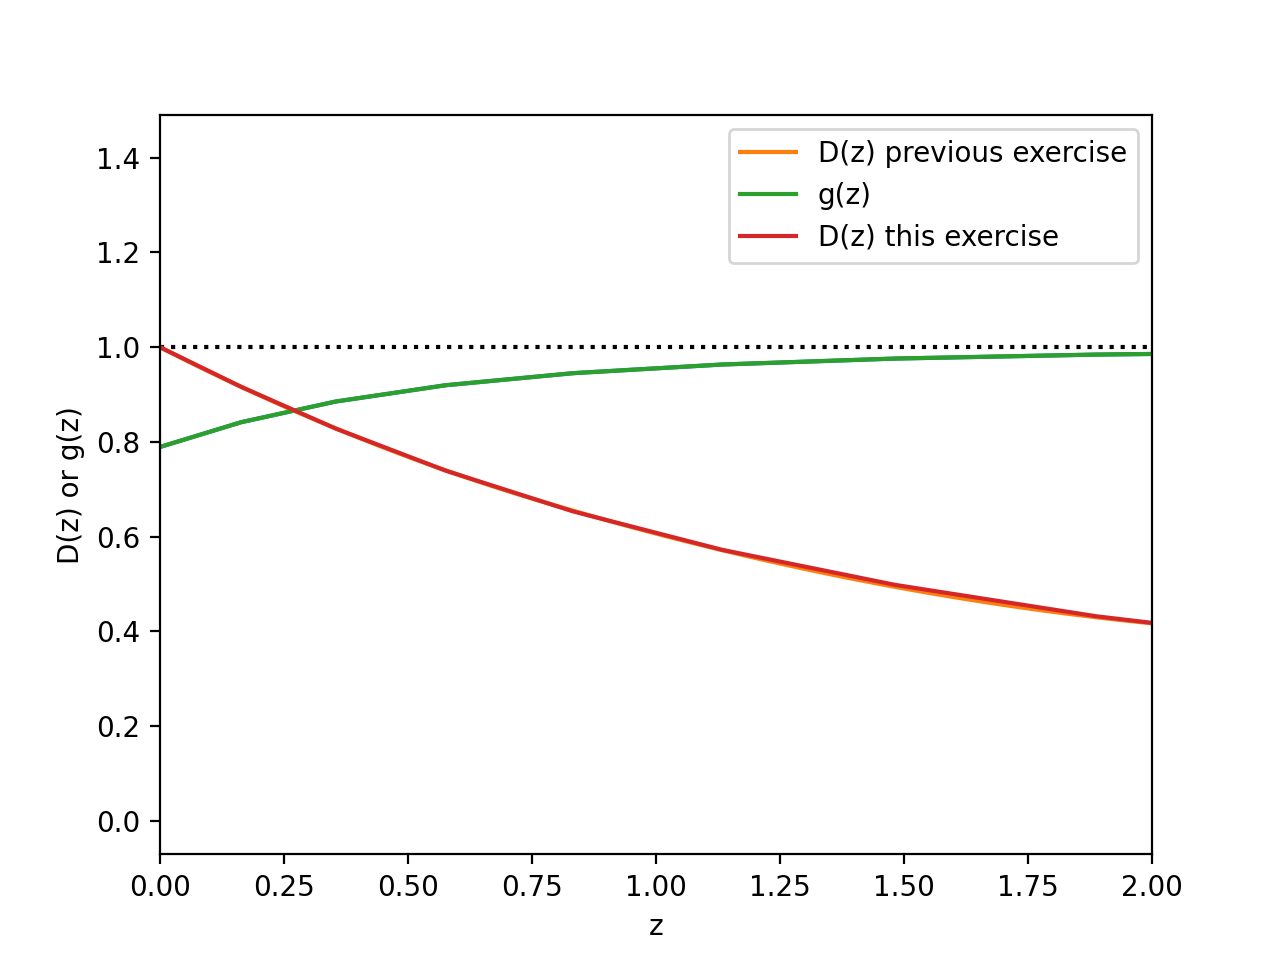

0.7893086795397901


In [10]:
ln_a = np.linspace(-5, 10, 100)
print(ln_a)
sol = solve_ivp(fun = equation_g, t_span = [ln_a[0], ln_a[-1]], y0 =[1, 0], t_eval = ln_a)

#plt.plot(sol.t, sol.y[0])
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(1/np.exp(sol.t)-1, sol.y[0])
g_a_interp = scipy.interpolate.interp1d(ln_a,sol.y[0] , kind='quadratic')
g_a_at1 = g_a_interp(0)
print(g_a_at1)
#print(1/g_a_at1-1)
plt.axhline(1, ls='dotted', color='black')

z = np.linspace(0,2, 100)
plt.plot(z, D(z), label='D(z) previous exercise')
plt.plot(1/np.exp(sol.t)-1, sol.y[0], label='g(z)')
D_new = g_a_interp(ln_a) * np.exp(ln_a)
normalization = D_new[np.where(ln_a ==0)[0]] #==0.78, but we want it to start at 1 like I chose before
D_new = D_new/normalization
plt.plot(1/np.exp(ln_a)-1, D_new, label ='D(z) this exercise')
plt.xlim(0, 2)
plt.legend()
plt.xlabel('z')
plt.ylabel('D(z) or g(z)')
plt.show()

$\mathrm{\textbf{Halo Mass Function}}\\\\$
The simulation we are using has a box size of 1h−1 Gpc, and has $1024^3$ particles. I sum up all the masses (200c) and divide by $1024^3$ to get the mass of 1 particle. I find ~$1.5x10^{10}$ Msun. I plot the halo mass function which is usually plotted as $dlnM/dM = M N$.
$$\\\\$$
I am plotting log10(M) on the x-axis and the mass in each bin times the amount of galaxies in each bin on the y axis with log scale. 
For the simulations there is a turnover at masses lower than $10^{13}$ Msun due to resolution effects. For these galaxies there are only 100 particles in the galaxy. For example are no galaxies with masses lower than a few $10^{10}$ Msun, that would mean only 1 particle in the galaxy. I am plotting this together with the Press-Schechter Mass function at z=0 and z=1 (see final figure). They agree reasonably well, with a slight deviation at the highest mass end. 
$$\\\\$$
I calculate $\sigma(M)$ with the same function as used before for $\sigma_8$, for a range of masses. 

In [11]:
dtypes = np.array([float, float, float])
Mvir, M200c, M200b = np.genfromtxt(path+ f'HW5/halo_z=0.txt', delimiter=' ', unpack =True, dtype=dtypes) 
print((np.sum(M200c[M200c>0])/1024**3)/1e10) #~1.5e10 Msun/h

1.473173647542484


In [12]:
def halo_mass_function(z):
	dtypes = np.array([float, float, float])
	Mvir, M200c, M200b = np.genfromtxt(path+ f'HW5/halo_z={z}.txt', delimiter=' ', unpack =True, dtype=dtypes) 
	x = np.linspace(np.min(Mvir[Mvir>0]), np.max(Mvir[Mvir>0]), 100)
	
	N, Bins = np.histogram(np.log10(Mvir[Mvir>0]), bins =20)

	rho0 = 2.7754 *1e11 #h^2 Msun Mpc-3  (from 3*H0**2/(8*pi*G)) 
	M = 10**np.linspace(12, 15.5, 50)
	R = (M * 3/4 * 1/np.pi * 1/(rho0))**(1./3.)

	sigma_8 = np.sqrt(sigma_squared(8, n))
	sigmas = np.zeros(len(R))
	for i in range(len(R)):
		sigmas[i] = np.sqrt(sigma_squared(R[i], n))

	sigma_8 = np.sqrt(sigma_squared(8, n))
	print(sigma_8)
	sigma_M = sigmas

	dc_t = 1.686/D(z)
	nu = dc_t / sigma_M
	f_PS = np.sqrt(2/np.pi) * nu * np.exp(-nu**2/2) # unitless
	#n(M,t) = dn/dM = 1/M dn/dlnM
	#we are plotting dn/dlnM = n * M 
	gradient = np.gradient(np.log(nu), np.log(M))
	dln_M_dm = rho0/M**2 * f_PS * np.abs(gradient) *  M #units of h^2 Msun Mpc-3 / (Msun h-1) = h^3 Mpc-3
	return M, sigma_M, np.log10(M), dln_M_dm, (Bins[1:] +Bins[:-1])/2, (Bins[1:] +Bins[:-1])/2 * N*10**(-9) #1e-9 takes care of going from Gpc-3 to Mpc-3


<IPython.core.display.Javascript object>


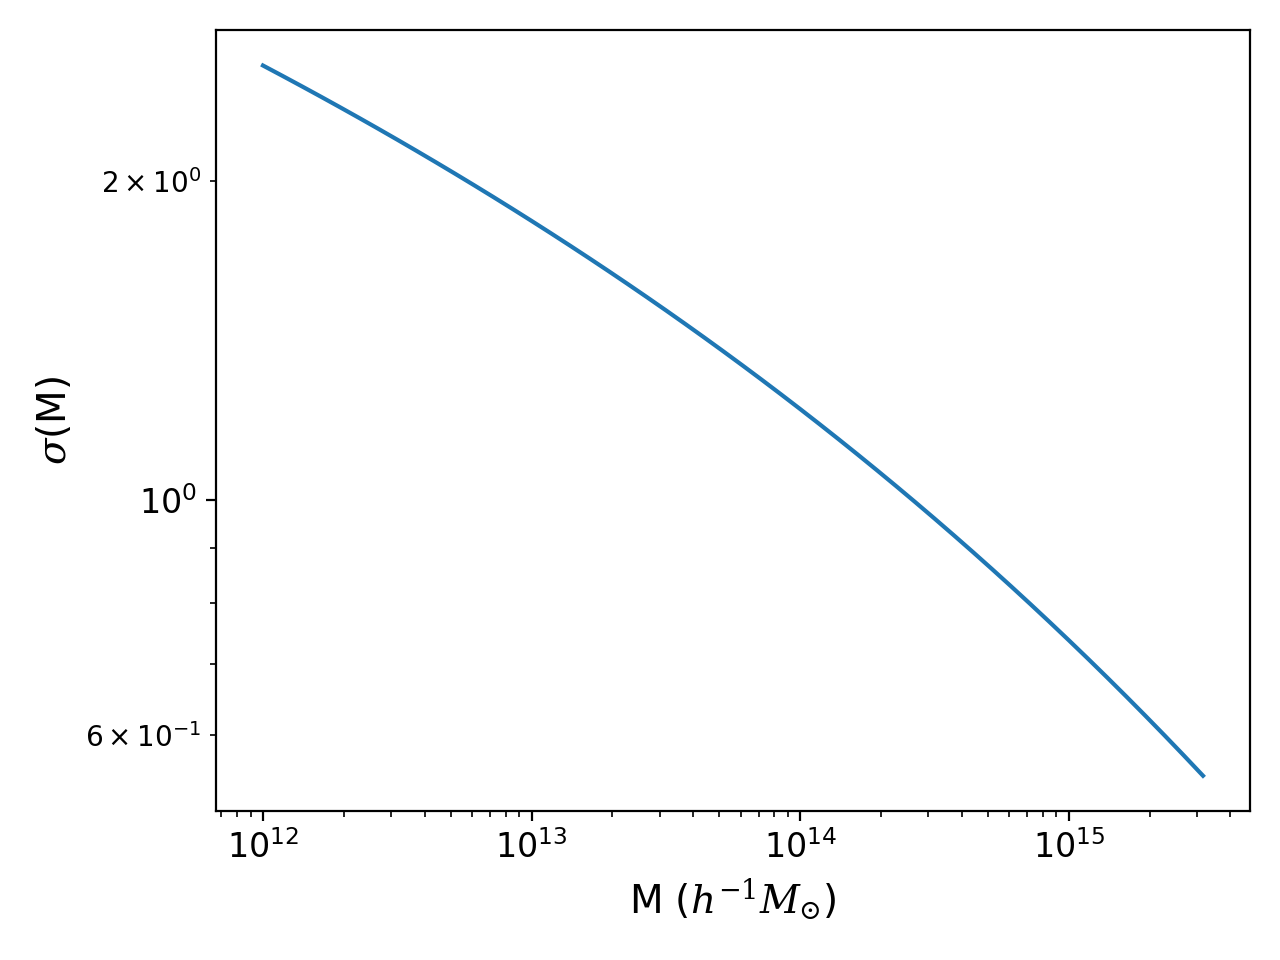

/var/folders/bg/b8pbm9h90v9d199r8jsxsf840000gn/T/ipykernel_16549/25706461.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = quad(integrand, 0, np.inf, args = (Ri, n))
/var/folders/bg/b8pbm9h90v9d199r8jsxsf840000gn/T/ipykernel_16549/25706461.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = quad(integrand, 0, np.inf, args = (Ri, n))


0.8335126029557834


<IPython.core.display.Javascript object>


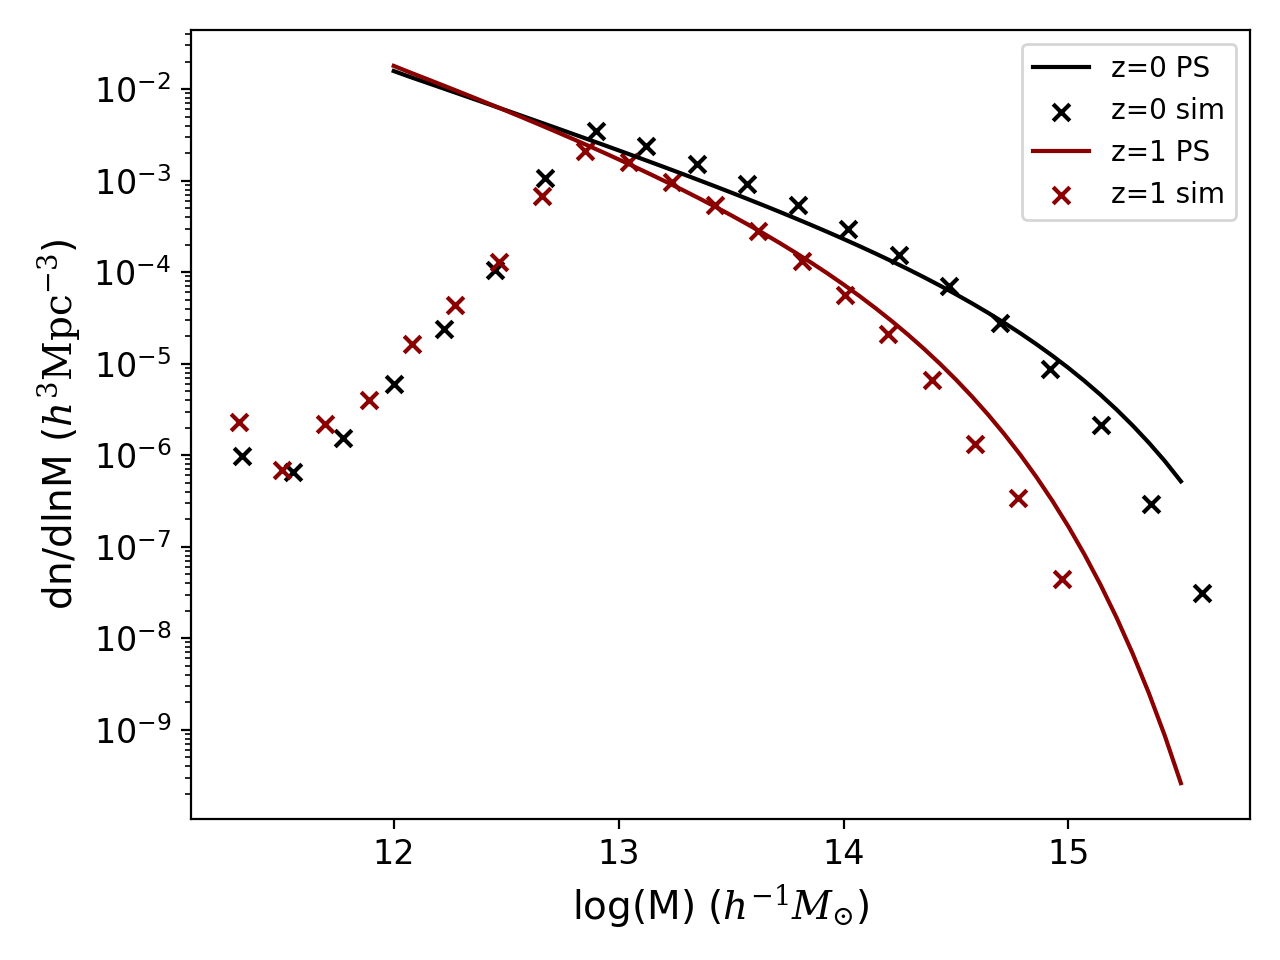

0.8335126029557834


In [13]:
fig = plt.figure()
ax=fig.add_subplot()

M, sigma_M, log_M_PS, dnln_PS, logM_sim, dnln_sim = halo_mass_function(0)
ax.plot(M, sigma_M)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel(r'M ($h^{-1} M_{\odot}$)', fontsize=14)
ax.set_ylabel(r'$\sigma$(M)', fontsize=14)
plt.tight_layout()
plt.show()

fig = plt.figure()
ax=fig.add_subplot()
ax.plot(log_M_PS, dnln_PS, color='black', label='z=0 PS')
ax.scatter(logM_sim, dnln_sim, color='black', marker='x', label='z=0 sim')

M, sigma_M, log_M_PS, dnln_PS, logM_sim, dnln_sim = halo_mass_function(1)
ax.plot(log_M_PS, dnln_PS, color='darkred', label='z=1 PS')
ax.scatter(logM_sim, dnln_sim, color='darkred', marker='x', label='z=1 sim')

ax.set_yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel(r'log(M) ($h^{-1} M_{\odot}$)', fontsize=14)
ax.set_ylabel(r'dn/dlnM ($h^3 \mathrm{Mpc}^{-3}$)', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()